In [1]:
import time
import numpy as np
from numpy import mean, std, dstack
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, matthews_corrcoef
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, Dropout, InputLayer
from tensorflow.keras.callbacks import History
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Layer
import xlsxwriter
from tensorflow.keras.regularizers import l2
from keras import layers
import keras
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

In [2]:
class Time2Vec(Layer):
    def __init__(self, kernel_size=1):
        super(Time2Vec, self).__init__()
        self.k = kernel_size

    def build(self, input_shape):
        self.w0 = self.add_weight(name="w0", shape=(1,), initializer="uniform", trainable=True)
        self.b0 = self.add_weight(name="b0", shape=(1,), initializer="uniform", trainable=True)
        self.w = self.add_weight(name="w", shape=(input_shape[-1], self.k), initializer="uniform", trainable=True)
        self.b = self.add_weight(name="b", shape=(self.k,), initializer="uniform", trainable=True)

    def call(self, inputs):
        v1 = self.w0 * inputs + self.b0
        v2 = tf.math.sin(tf.matmul(inputs, self.w) + self.b)
        return tf.concat([v1, v2], axis=-1)

In [3]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [4]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_classes,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv1D(filters=64, kernel_size=8, activation='relu', bias_regularizer='l2')(inputs)
    x = layers.MaxPooling1D(pool_size=17,strides=9)(x)
    x = Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)

    x = Time2Vec()(x)

    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)


In [5]:
def evaluate_model(trainX, trainy, testX, testy, sujet):
    verbose, epochs, batch_size = 1, 200, 64
    # Extract dimensions from training data:
    n_timesteps = trainX.shape[1]
    d_model= trainX.shape[2]  # This is 12 in your case
    n_outputs = trainy.shape[1]

    print("Train Data Shape:", trainX.shape)  # (num_samples, sequence_length, 12)
    print("Test Data Shape:", testX.shape)

    # Build the classifier model using the raw input dimension and then projecting internally.
    model = build_model(
       input_shape=(n_timesteps, d_model),
       head_size=128,
       num_heads=12,
       num_classes=n_outputs,
       ff_dim=24,
       num_transformer_blocks=1,
       mlp_units=[128],
       mlp_dropout=0.4,
       dropout=0.25,
    )
    model.summary()

    # Compile the model with categorical crossentropy and Adam optimizer.
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.0001),
                  metrics=['accuracy'])


    # Train the model
    start = time.time()
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[history])
    train_time = time.time() - start  # seconds

    # Save the model
    model.save('D:\Transformer-Based-approach-for-hand-gesture-recognition-through-EMG-signals\DB3\models\Transformer_model_' + str(sujet) + '.h5')

    # Evaluate on training data
    loss_train, accuracy_train = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=1)
    start = time.time()
    loss_test, accuracy_test = model.evaluate(testX, testy, batch_size=batch_size, verbose=1)
    test_time = time.time() - start  # seconds

    # Predict on test data and convert predictions to class indices
    y_pred = np.argmax(model.predict(testX), axis=-1)
    testy_indices = [np.argmax(y) for y in testy]

    return loss_train, accuracy_train, loss_test, accuracy_test, y_pred, testy_indices, train_time, test_time


def summarize_results(scores, losses):
    m, s = mean(scores), std(scores)
    mL, sL = mean(losses), std(losses)
    print('\nAccuracy: %.5f (+/-%.5f)' % (m, s))
    print('Loss: %.5f (+/-%.5f)' % (mL, sL))

def run_my_experiment(sujet):
    # Load data from MATLAB file; update the path as needed.
    data = loadmat(fr"D:\Transformer-Based-approach-for-hand-gesture-recognition-through-EMG-signals\DB3\data\normalized_data\DB3_s" + str(sujet) + "_E1_A1_150_100_N.mat")

    train_data = data['train_data']      # shape: (num_train_samples, sequence_length, d_model)
    train_labels = data['train_labels']    # shape: (num_train_samples, num_classes)
    test_data = data['test_data']          # shape: (num_test_samples, sequence_length, d_model)
    test_labels = data['test_labels']      # shape: (num_test_samples, num_classes)

    scores = list()
    losses = list()

    loss_train, score_train, loss_test, score_test, y_pred, testy, train_time, test_time = evaluate_model(
        train_data, train_labels, test_data, test_labels, sujet
    )

    print('>#%d: ' % (sujet))
    print('  train accuracy: %.5f' % (score_train))
    print('  train loss    : %.5f' % (loss_train))
    print('  test accuracy: %.5f' % (score_test))
    print('  test loss    : %.5f' % (loss_test))
    scores.append(score_test)
    losses.append(loss_test)
    summarize_results(scores, losses)

    return loss_train, score_train, loss_test, score_test, y_pred, testy, train_time, test_time


<>:37: SyntaxWarning: invalid escape sequence '\T'
<>:37: SyntaxWarning: invalid escape sequence '\T'
C:\Users\ycn\AppData\Local\Temp\ipykernel_1816\1147633658.py:37: SyntaxWarning: invalid escape sequence '\T'
  model.save('D:\Transformer-Based-approach-for-hand-gesture-recognition-through-EMG-signals\DB3\models\Transformer_model_' + str(sujet) + '.h5')


Train Data Shape: (3105, 300, 12)
Test Data Shape: (1431, 300, 12)



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 293, 64)   │      6,208 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 31, 64)    │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 31, 64)    │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 31, 64)    │        256 │ dropout[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec           │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec[0][0],  │
│ (MultiHeadAttentio… │                   │            │ time2_vec[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 31, 65)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 31, 65)    │        130 │ dropout_2[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 31, 24)    │      1,584 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 31, 24)    │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 31, 65)    │      1,625 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_2[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_1[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │      2,064 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 197ms/step - accuracy: 0.0695 - loss: 2.8764
Epoch 2/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 190ms/step - accuracy: 0.0943 - loss: 2.6915
Epoch 3/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step - accuracy: 0.0922 - loss: 2.6707
Epoch 4/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 189ms/step - accuracy: 0.1384 - loss: 2.6194
Epoch 5/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.1341 - loss: 2.5764
Epoch 6/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step - accuracy: 0.1809 - loss: 2.5024
Epoch 7/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 194ms/step - accuracy: 0.2110 - loss: 2.3817
Epoch 8/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 200ms/step - accuracy: 0.1920 - loss: 2.3707
Epoch 9/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 198ms/step - accuracy: 0.2332 - loss: 2.2669
Epoch 10/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.2630 - loss: 2.1673
Epoch 11/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - accuracy: 0.2714 - loss: 2.1449
Epoch 12/200
49/49 ━━━━━━━━━━━━━

49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.7459 - loss: 0.6788
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.5457 - loss: 1.4643
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
>#1: 
  train accuracy: 0.80064
  train loss    : 0.59732
  test accuracy: 0.57023
  test loss    : 1.54262

Accuracy: 0.57023 (+/-0.00000)
Loss: 1.54262 (+/-0.00000)


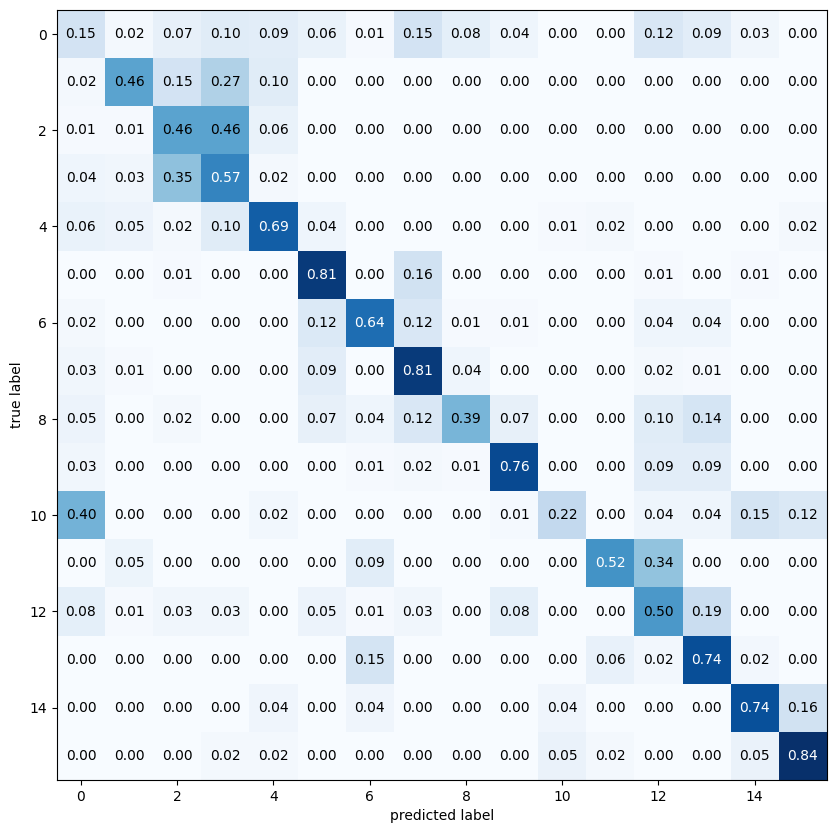

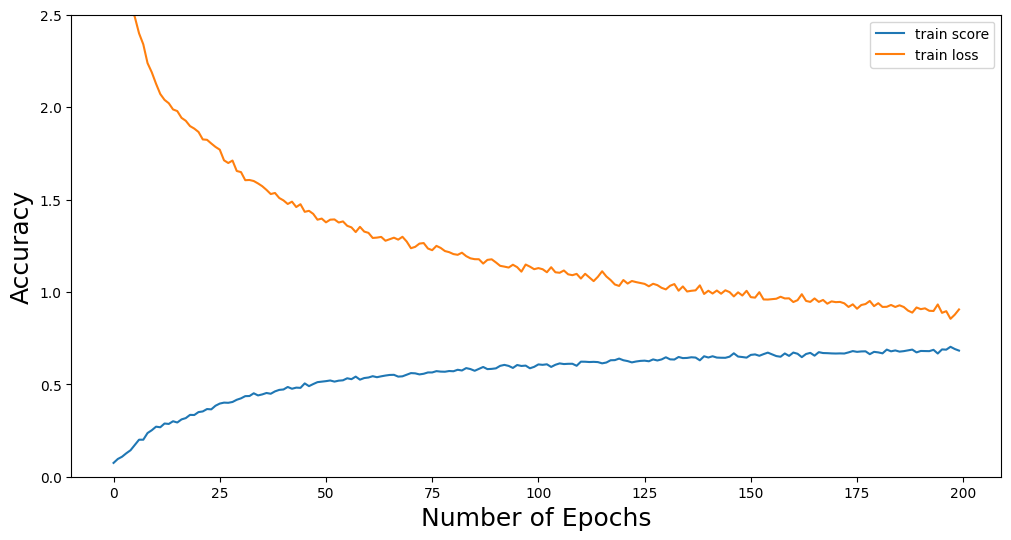

Train Data Shape: (2434, 300, 12)
Test Data Shape: (1075, 300, 12)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 293, 64)   │      6,208 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 31, 64)    │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 31, 64)    │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_5[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_1         │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_1[0][0… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 31, 65)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_7[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 31, 24)    │      1,584 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 31, 24)    │          0 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 31, 65)    │      1,625 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_5[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_3[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 16)        │      2,064 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 15s 183ms/step - accuracy: 0.0788 - loss: 2.9325
Epoch 2/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms/step - accuracy: 0.1237 - loss: 2.6961
Epoch 3/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 180ms/step - accuracy: 0.1292 - loss: 2.6147
Epoch 4/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 182ms/step - accuracy: 0.1508 - loss: 2.5214
Epoch 5/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 186ms/step - accuracy: 0.1665 - loss: 2.4802
Epoch 6/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms/step - accuracy: 0.1932 - loss: 2.4176
Epoch 7/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 185ms/step - accuracy: 0.2065 - loss: 2.3966
Epoch 8/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 188ms/step - accuracy: 0.2503 - loss: 2.3032
Epoch 9/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 185ms/step - accuracy: 0.2621 - loss: 2.2560
Epoch 10/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 183ms/step - accuracy: 0.2687 - loss: 2.1960
Epoch 11/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 183ms/step - accuracy: 0.2825 - loss: 2.1837
Epoch 12/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.8306 - loss: 0.5389
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.6550 - loss: 1.1733
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
>#2: 
  train accuracy: 0.78965
  train loss    : 0.60644
  test accuracy: 0.62512
  test loss    : 1.27185

Accuracy: 0.62512 (+/-0.00000)
Loss: 1.27185 (+/-0.00000)


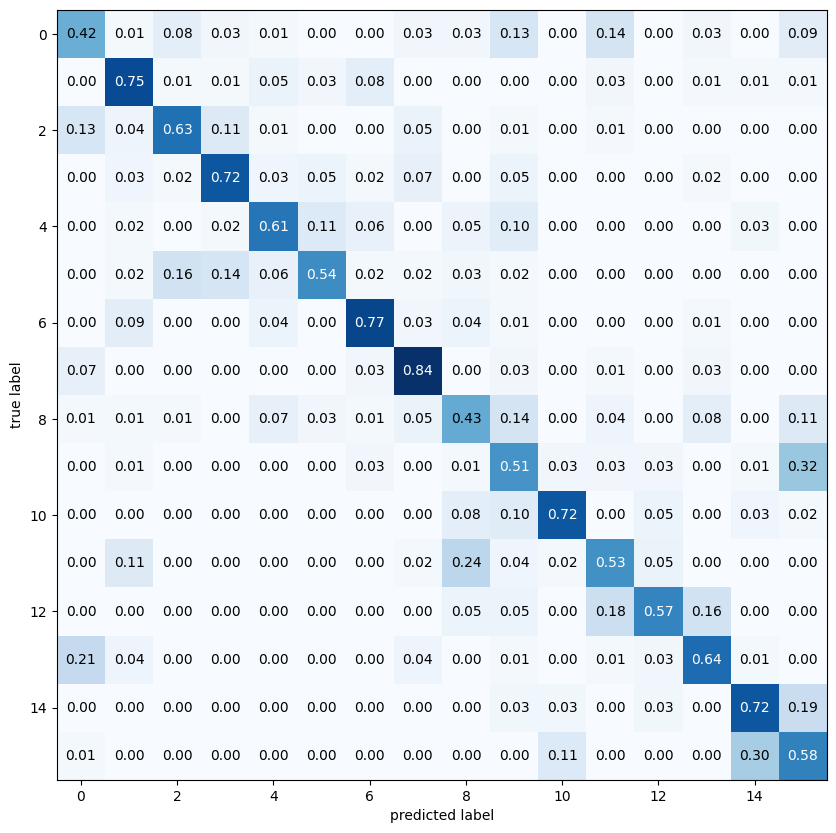

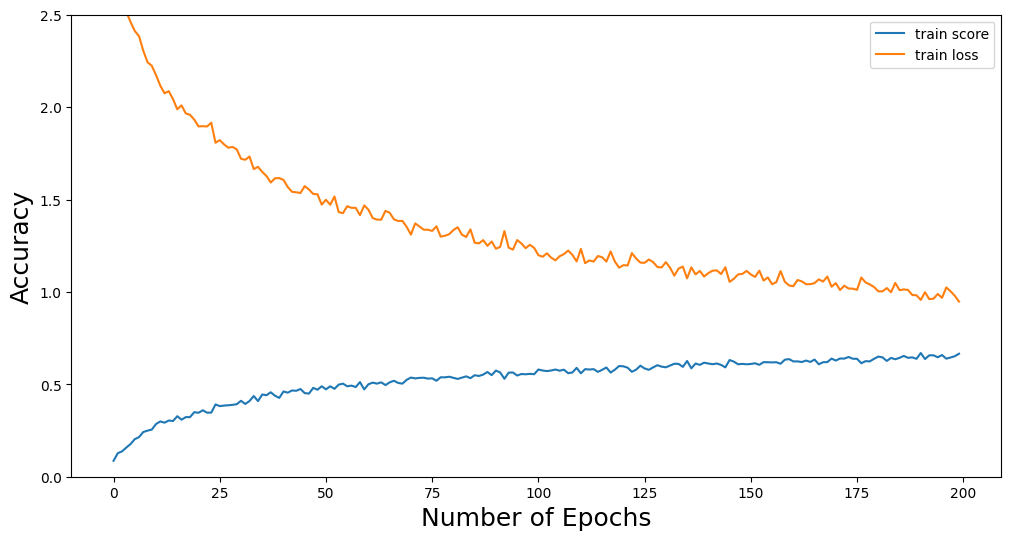

Train Data Shape: (1974, 300, 12)
Test Data Shape: (969, 300, 12)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 293, 64)   │      6,208 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 31, 64)    │          0 │ conv1d_6[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 31, 64)    │          0 │ max_pooling1d_2[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_10[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_2         │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_2[0][0… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_12[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 31, 24)    │      1,584 │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 31, 24)    │          0 │ conv1d_7[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 31, 65)    │      1,625 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_8[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_5[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 128)       │          0 │ dense_4[0][0]     │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 188ms/step - accuracy: 0.0823 - loss: 2.9253
Epoch 2/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - accuracy: 0.1122 - loss: 2.7277
Epoch 3/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - accuracy: 0.1629 - loss: 2.6449
Epoch 4/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - accuracy: 0.1820 - loss: 2.5776
Epoch 5/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - accuracy: 0.1870 - loss: 2.5616
Epoch 6/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.1998 - loss: 2.4942
Epoch 7/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - accuracy: 0.2051 - loss: 2.4965
Epoch 8/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - accuracy: 0.2237 - loss: 2.4931
Epoch 9/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - accuracy: 0.2200 - loss: 2.4524
Epoch 10/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step - accuracy: 0.2330 - loss: 2.3952
Epoch 11/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - accuracy: 0.2487 - loss: 2.3961
Epoch 12/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.8977 - loss: 0.3412
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5289 - loss: 1.6662
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
>#3: 
  train accuracy: 0.85866
  train loss    : 0.44142
  test accuracy: 0.49226
  test loss    : 1.81684

Accuracy: 0.49226 (+/-0.00000)
Loss: 1.81684 (+/-0.00000)


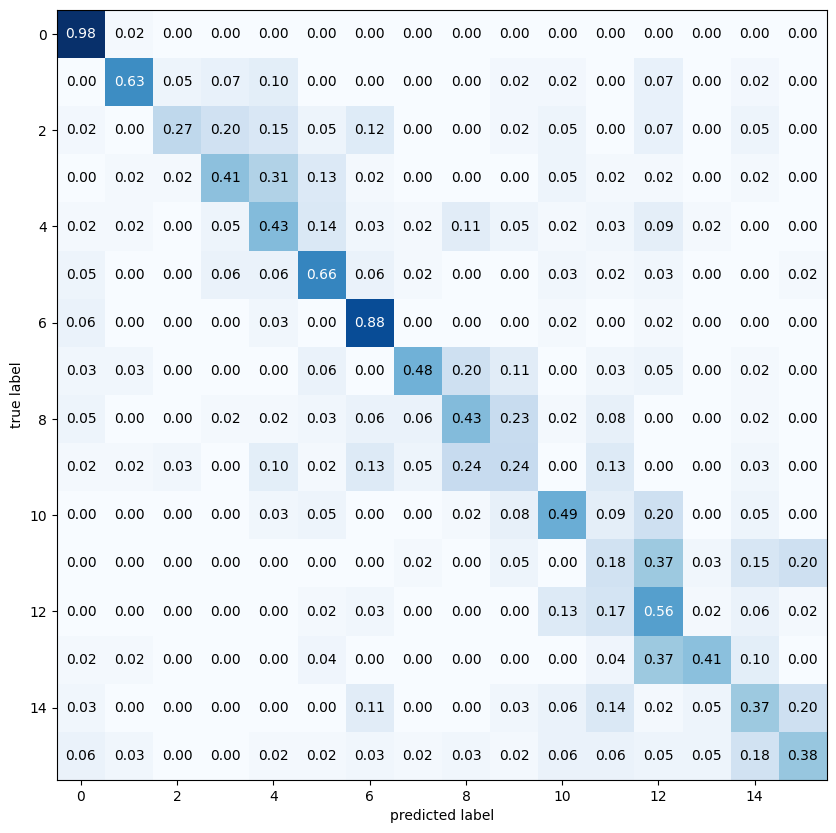

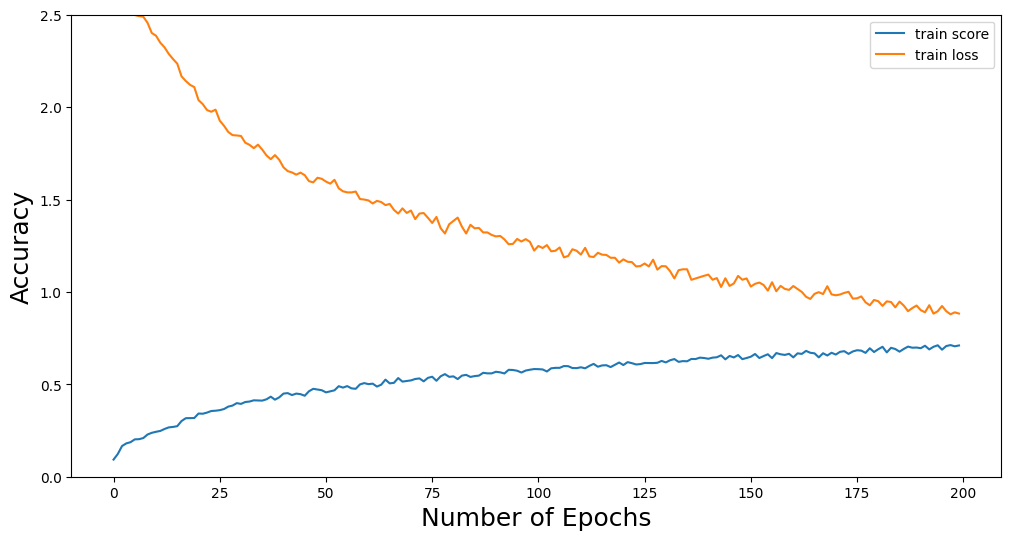

Train Data Shape: (4025, 300, 12)
Test Data Shape: (1985, 300, 12)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 293, 64)   │      6,208 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 31, 64)    │          0 │ conv1d_9[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 31, 64)    │          0 │ max_pooling1d_3[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_15[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_3         │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_3[0][0… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_17[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 31, 24)    │          0 │ conv1d_10[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_11[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_7[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 128)       │          0 │ dense_6[0][0]     │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 188ms/step - accuracy: 0.0646 - loss: 2.9068
Epoch 2/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 187ms/step - accuracy: 0.0754 - loss: 2.7712
Epoch 3/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 191ms/step - accuracy: 0.1011 - loss: 2.7004
Epoch 4/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 188ms/step - accuracy: 0.1061 - loss: 2.6545
Epoch 5/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 188ms/step - accuracy: 0.1387 - loss: 2.5674
Epoch 6/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 191ms/step - accuracy: 0.1671 - loss: 2.4637
Epoch 7/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 188ms/step - accuracy: 0.2011 - loss: 2.4095
Epoch 8/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 190ms/step - accuracy: 0.2221 - loss: 2.3005
Epoch 9/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 192ms/step - accuracy: 0.2427 - loss: 2.2190
Epoch 10/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 190ms/step - accuracy: 0.2608 - loss: 2.1680
Epoch 11/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 193ms/step - accuracy: 0.2853 - loss: 2.1207
Epoch 12/200
63/63 ━━━━━━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.8517 - loss: 0.4376
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.5339 - loss: 1.4748
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step
>#4: 
  train accuracy: 0.83304
  train loss    : 0.49917
  test accuracy: 0.48917
  test loss    : 1.63931

Accuracy: 0.48917 (+/-0.00000)
Loss: 1.63931 (+/-0.00000)


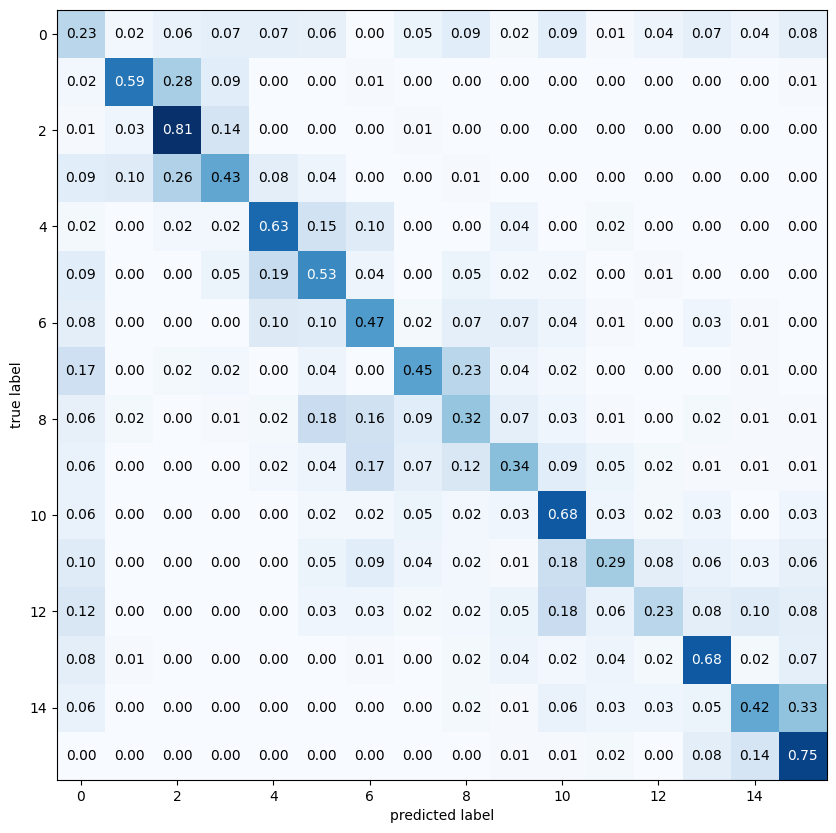

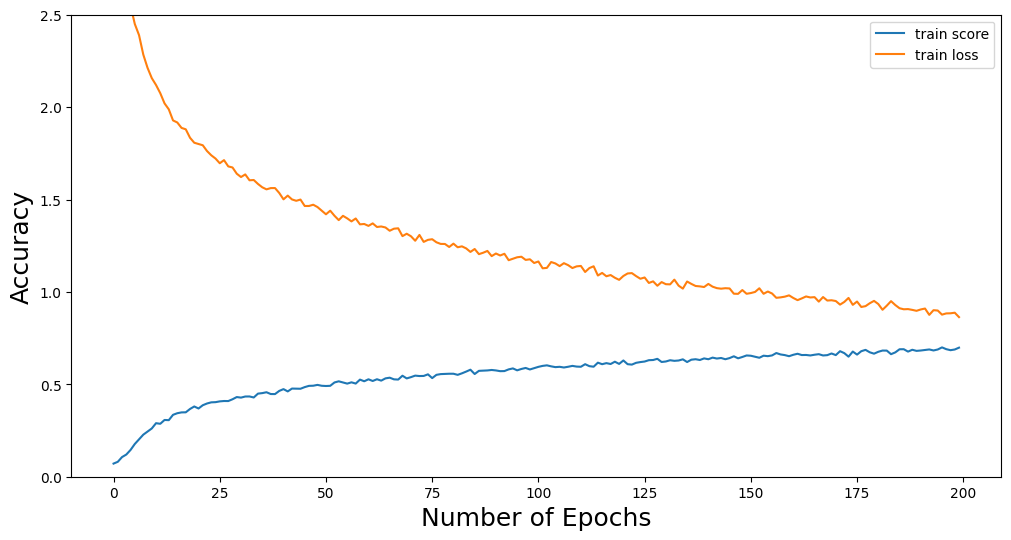

Train Data Shape: (3717, 300, 12)
Test Data Shape: (1993, 300, 12)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 31, 64)    │          0 │ conv1d_12[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 31, 64)    │          0 │ max_pooling1d_4[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_20[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_4         │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_4[0][0… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_22[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 31, 24)    │          0 │ conv1d_13[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_14[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_9[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 128)       │          0 │ dense_8[0][0]     │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 18s 185ms/step - accuracy: 0.0785 - loss: 2.9052
Epoch 2/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 11s 191ms/step - accuracy: 0.1051 - loss: 2.7300
Epoch 3/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 20s 187ms/step - accuracy: 0.1159 - loss: 2.6714
Epoch 4/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 11s 185ms/step - accuracy: 0.1265 - loss: 2.6326
Epoch 5/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 11s 190ms/step - accuracy: 0.1593 - loss: 2.5654
Epoch 6/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 11s 187ms/step - accuracy: 0.1662 - loss: 2.5277
Epoch 7/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 11s 190ms/step - accuracy: 0.2123 - loss: 2.3989
Epoch 8/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - accuracy: 0.2484 - loss: 2.3130
Epoch 9/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 11s 186ms/step - accuracy: 0.2961 - loss: 2.1677
Epoch 10/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 11s 191ms/step - accuracy: 0.3365 - loss: 2.0551
Epoch 11/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 11s 187ms/step - accuracy: 0.3518 - loss: 1.9711
Epoch 12/200
59/59 ━━━━━━━━━━━

59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.9254 - loss: 0.2647
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.7253 - loss: 1.2197
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step
>#5: 
  train accuracy: 0.92333
  train loss    : 0.26047
  test accuracy: 0.62168
  test loss    : 1.81505

Accuracy: 0.62168 (+/-0.00000)
Loss: 1.81505 (+/-0.00000)


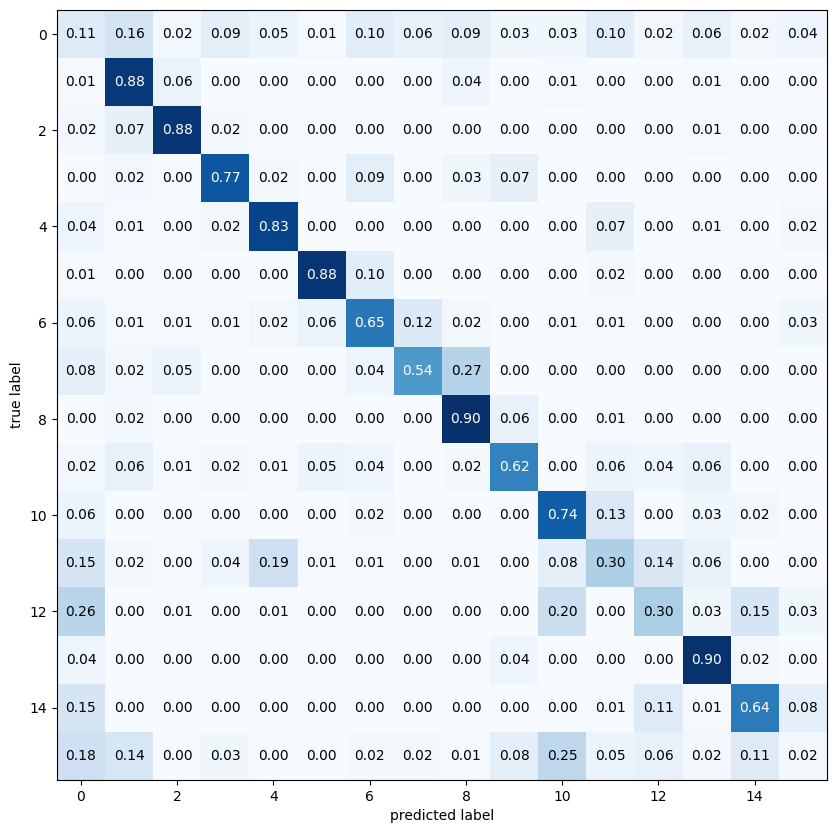

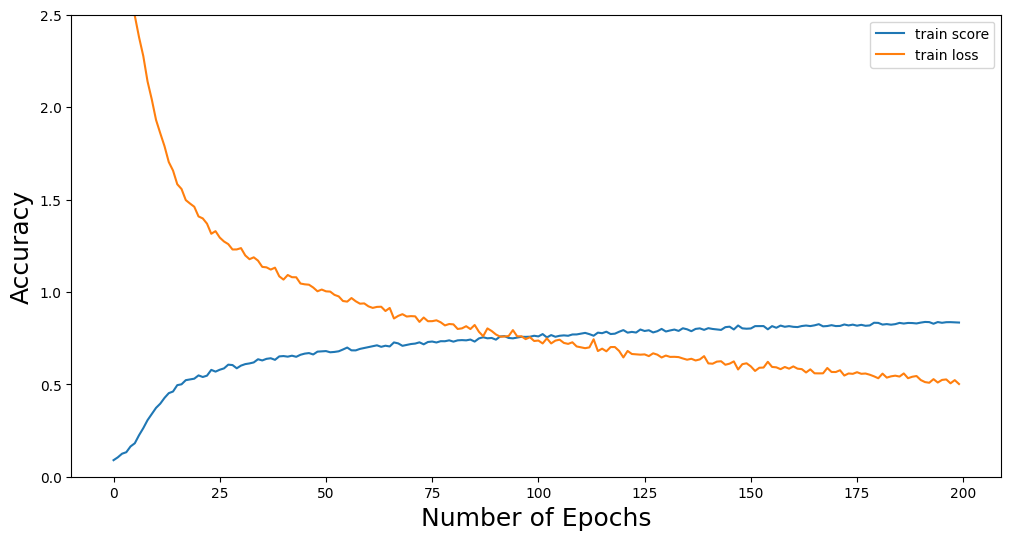

Train Data Shape: (4021, 300, 12)
Test Data Shape: (2013, 300, 12)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 31, 64)    │          0 │ conv1d_15[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 31, 64)    │          0 │ max_pooling1d_5[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_25[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_5         │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_5[0][0… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_27[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 31, 24)    │          0 │ conv1d_16[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_17[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_11[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 128)       │          0 │ dense_10[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 185ms/step - accuracy: 0.0908 - loss: 2.8426
Epoch 2/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 191ms/step - accuracy: 0.1363 - loss: 2.5321
Epoch 3/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - accuracy: 0.1748 - loss: 2.3783
Epoch 4/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 187ms/step - accuracy: 0.2071 - loss: 2.2420
Epoch 5/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 187ms/step - accuracy: 0.2618 - loss: 2.1122
Epoch 6/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 189ms/step - accuracy: 0.2923 - loss: 1.9952
Epoch 7/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 193ms/step - accuracy: 0.3201 - loss: 1.9135
Epoch 8/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 189ms/step - accuracy: 0.3382 - loss: 1.8167
Epoch 9/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 192ms/step - accuracy: 0.3578 - loss: 1.7922
Epoch 10/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 193ms/step - accuracy: 0.3610 - loss: 1.7500
Epoch 11/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - accuracy: 0.3912 - loss: 1.7186
Epoch 12/200
63/63 ━━━━━━━━━━━

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.7943 - loss: 0.5920
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.5150 - loss: 1.4846
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step
>#6: 
  train accuracy: 0.80801
  train loss    : 0.54690
  test accuracy: 0.56632
  test loss    : 1.33941

Accuracy: 0.56632 (+/-0.00000)
Loss: 1.33941 (+/-0.00000)


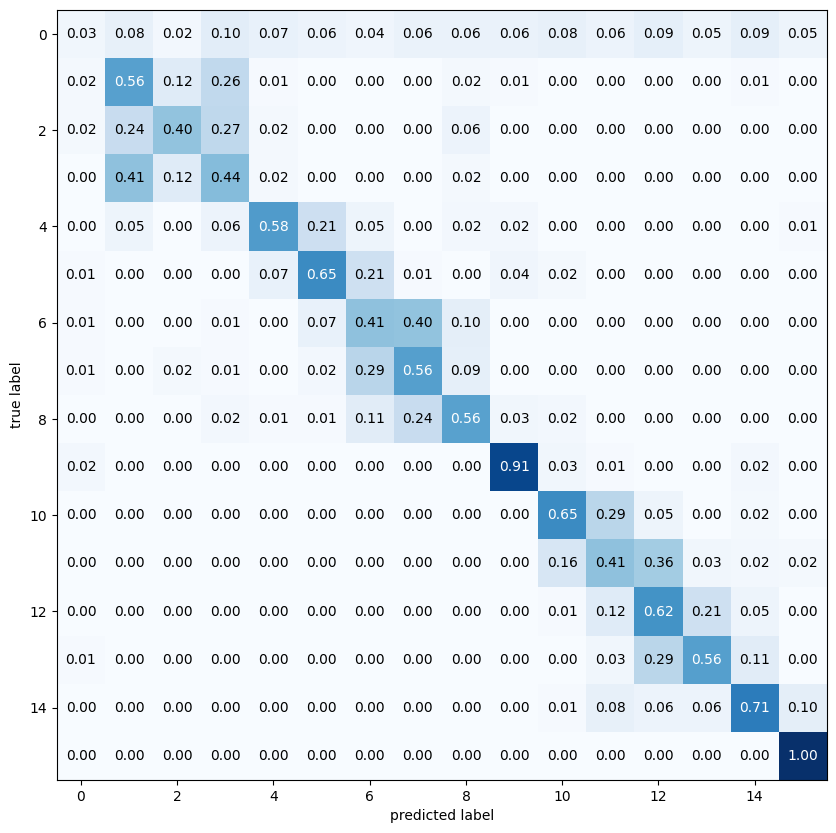

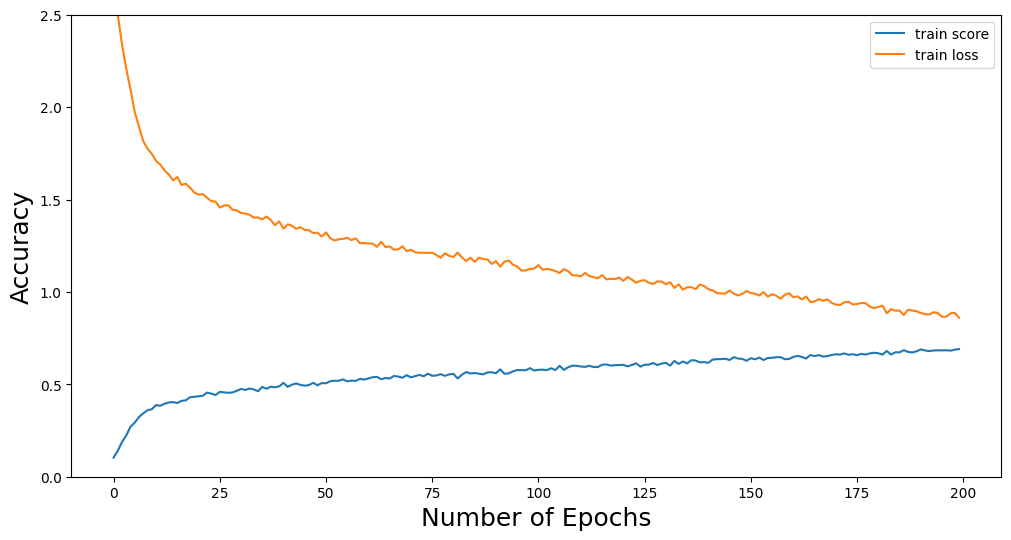

Train Data Shape: (3950, 300, 12)
Test Data Shape: (1980, 300, 12)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 31, 64)    │          0 │ conv1d_18[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 31, 64)    │          0 │ max_pooling1d_6[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_30[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_6         │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_6[0][0… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_32[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_12[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_33          │ (None, 31, 24)    │          0 │ conv1d_19[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_20 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_33[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_20[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_12[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_13[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_34          │ (None, 128)       │          0 │ dense_12[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 186ms/step - accuracy: 0.0672 - loss: 2.9284
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 192ms/step - accuracy: 0.0721 - loss: 2.7785
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 188ms/step - accuracy: 0.0721 - loss: 2.7801
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 186ms/step - accuracy: 0.0826 - loss: 2.7716
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 190ms/step - accuracy: 0.0759 - loss: 2.7671
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 190ms/step - accuracy: 0.0823 - loss: 2.7598
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - accuracy: 0.0847 - loss: 2.7530
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 212ms/step - accuracy: 0.0999 - loss: 2.7483
Epoch 9/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 198ms/step - accuracy: 0.0918 - loss: 2.7371
Epoch 10/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 192ms/step - accuracy: 0.1019 - loss: 2.7319
Epoch 11/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 189ms/step - accuracy: 0.1060 - loss: 2.7191
Epoch 12/200
62/62 ━━━━━━━━━━━

62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.6621 - loss: 1.2050
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.1381 - loss: 3.3269
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step
>#7: 
  train accuracy: 0.65646
  train loss    : 1.21471
  test accuracy: 0.13535
  test loss    : 3.33932

Accuracy: 0.13535 (+/-0.00000)
Loss: 3.33932 (+/-0.00000)


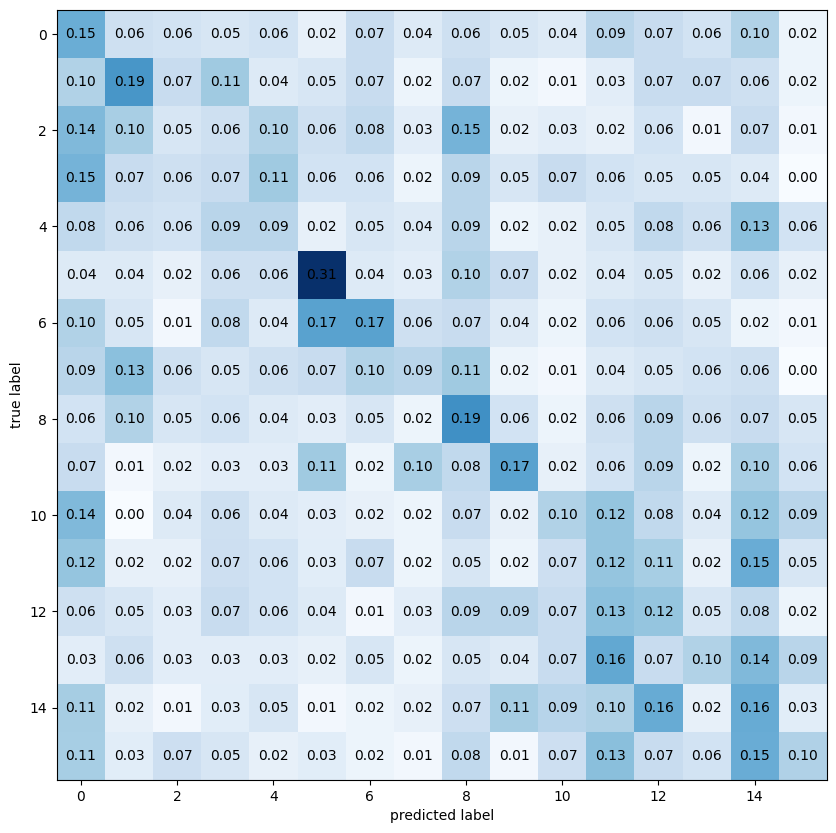

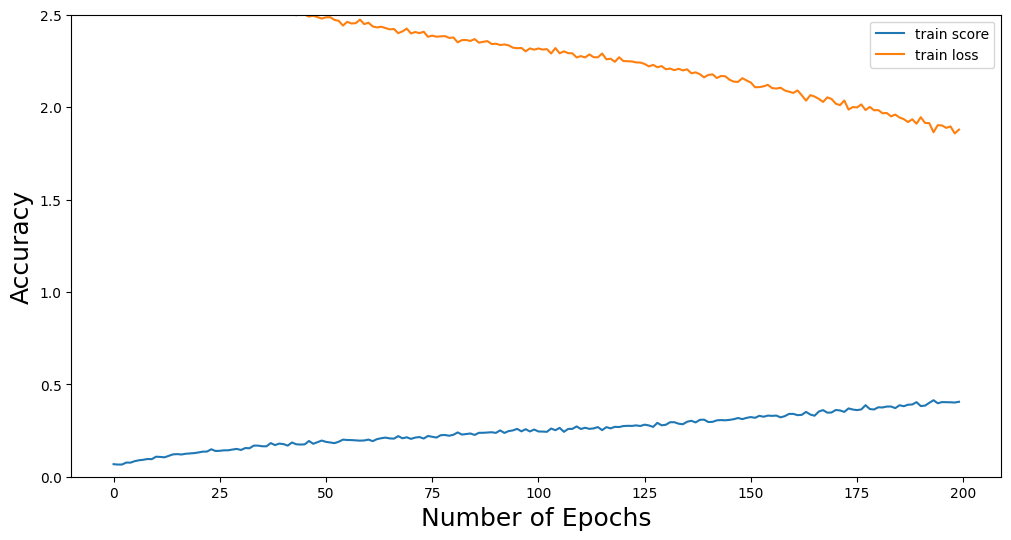

Train Data Shape: (1898, 300, 12)
Test Data Shape: (942, 300, 12)


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_21 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 31, 64)    │          0 │ conv1d_21[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_35          │ (None, 31, 64)    │          0 │ max_pooling1d_7[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_35[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_7         │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_7[0][0… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_37          │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_37[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_22 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_14[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_38          │ (None, 31, 24)    │          0 │ conv1d_22[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_23 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_38[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_23[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_15 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_14[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_15[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_39          │ (None, 128)       │          0 │ dense_14[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 216ms/step - accuracy: 0.1146 - loss: 2.7709
Epoch 2/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step - accuracy: 0.1555 - loss: 2.5149
Epoch 3/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step - accuracy: 0.1513 - loss: 2.4374
Epoch 4/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 210ms/step - accuracy: 0.1977 - loss: 2.3379
Epoch 5/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 217ms/step - accuracy: 0.2043 - loss: 2.2756
Epoch 6/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 210ms/step - accuracy: 0.2559 - loss: 2.1903
Epoch 7/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 219ms/step - accuracy: 0.2683 - loss: 2.1293
Epoch 8/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 221ms/step - accuracy: 0.2772 - loss: 2.0496
Epoch 9/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 218ms/step - accuracy: 0.2913 - loss: 1.9938
Epoch 10/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 219ms/step - accuracy: 0.2836 - loss: 1.9981
Epoch 11/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 228ms/step - accuracy: 0.2958 - loss: 1.9406
Epoch 12/200
30/30 ━━━━━━━━━━━━━━━━

30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.8665 - loss: 0.3466
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.5737 - loss: 1.7034
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step
>#8: 
  train accuracy: 0.84247
  train loss    : 0.41757
  test accuracy: 0.59554
  test loss    : 1.38653

Accuracy: 0.59554 (+/-0.00000)
Loss: 1.38653 (+/-0.00000)


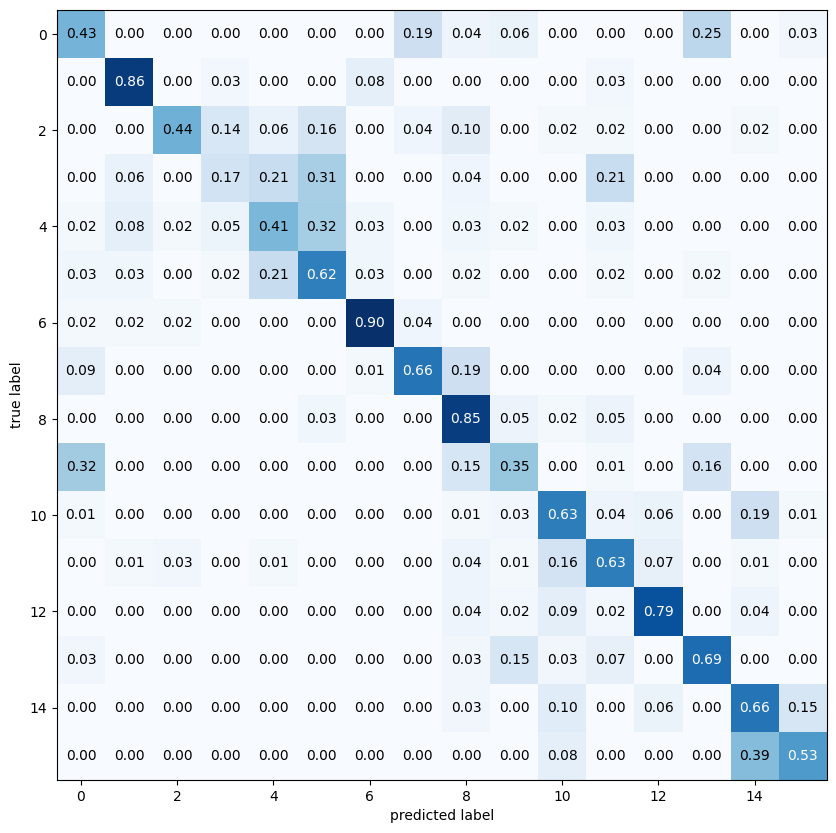

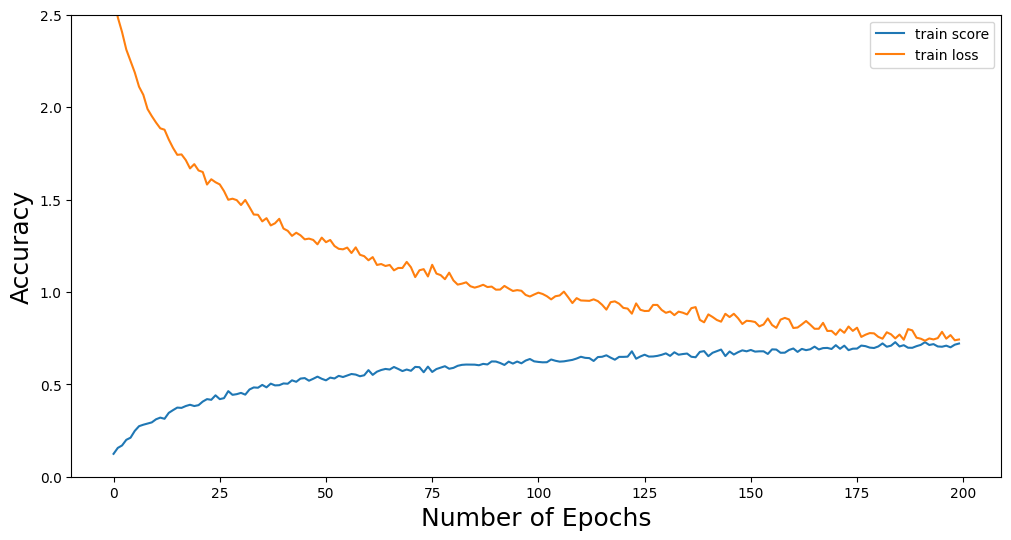

Train Data Shape: (2617, 300, 12)
Test Data Shape: (1365, 300, 12)


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_24 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_8     │ (None, 31, 64)    │          0 │ conv1d_24[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_40          │ (None, 31, 64)    │          0 │ max_pooling1d_8[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_40[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_8         │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_8[0][0… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_42          │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_42[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_25 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_16[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_43          │ (None, 31, 24)    │          0 │ conv1d_25[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_26 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_43[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_26[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_16[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_17[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_44          │ (None, 128)       │          0 │ dense_16[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 210ms/step - accuracy: 0.0797 - loss: 2.8876
Epoch 2/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 217ms/step - accuracy: 0.1610 - loss: 2.5489
Epoch 3/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 218ms/step - accuracy: 0.2121 - loss: 2.3893
Epoch 4/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 226ms/step - accuracy: 0.2519 - loss: 2.2101
Epoch 5/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step - accuracy: 0.3035 - loss: 2.0745
Epoch 6/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 210ms/step - accuracy: 0.3405 - loss: 1.9620
Epoch 7/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 219ms/step - accuracy: 0.3756 - loss: 1.8551
Epoch 8/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 219ms/step - accuracy: 0.3847 - loss: 1.7743
Epoch 9/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 220ms/step - accuracy: 0.4200 - loss: 1.7217
Epoch 10/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 221ms/step - accuracy: 0.4107 - loss: 1.7077
Epoch 11/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 220ms/step - accuracy: 0.4284 - loss: 1.6731
Epoch 12/200
41/41 ━━━━━━━━━━━━━━━━━

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.9143 - loss: 0.2534
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.7032 - loss: 0.9639
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
>#9: 
  train accuracy: 0.90676
  train loss    : 0.26755
  test accuracy: 0.66886
  test loss    : 1.07933

Accuracy: 0.66886 (+/-0.00000)
Loss: 1.07933 (+/-0.00000)


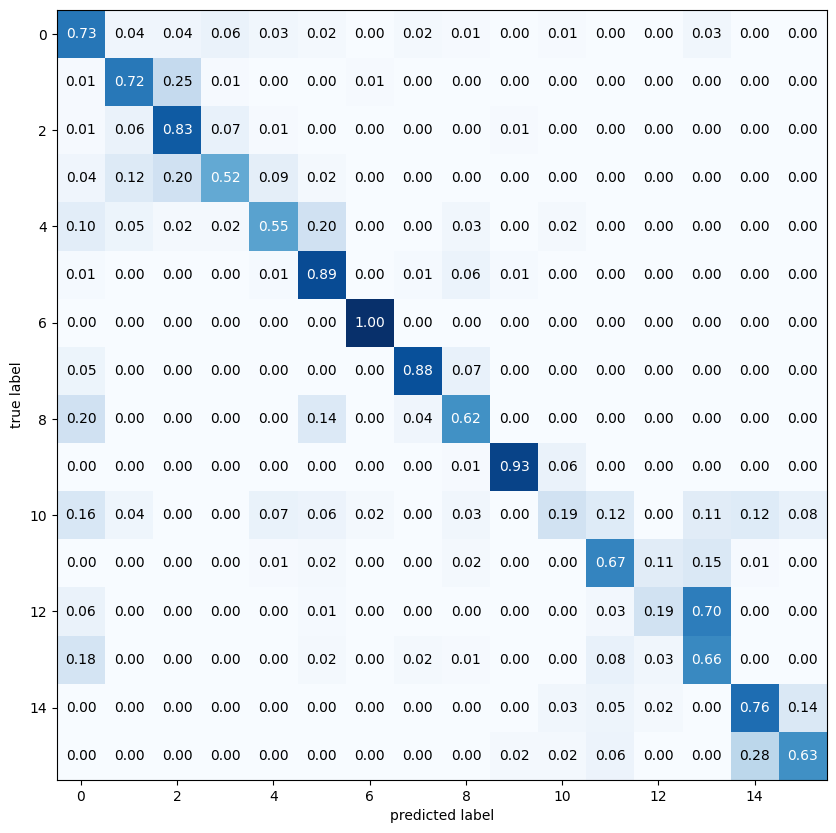

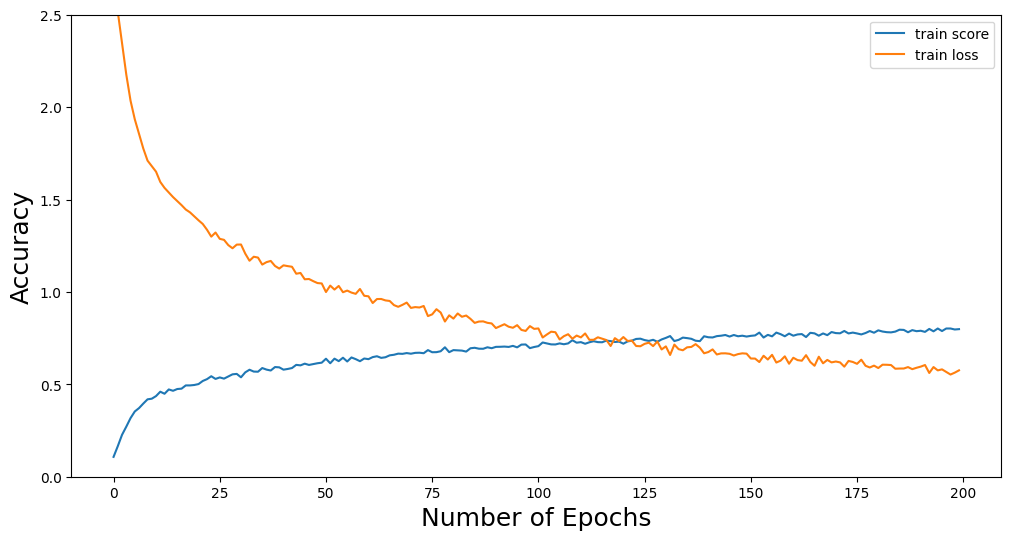

Train Data Shape: (3842, 300, 12)
Test Data Shape: (1953, 300, 12)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_27 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_9     │ (None, 31, 64)    │          0 │ conv1d_27[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_45          │ (None, 31, 64)    │          0 │ max_pooling1d_9[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_45[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_9         │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_9[0][0… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_9[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_47          │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_47[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_9[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_18[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_48          │ (None, 31, 24)    │          0 │ conv1d_28[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_29 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_48[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_29[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_19 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_18[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_19[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_49          │ (None, 128)       │          0 │ dense_18[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 213ms/step - accuracy: 0.0840 - loss: 2.8738
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 13s 209ms/step - accuracy: 0.1335 - loss: 2.6475
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - accuracy: 0.1941 - loss: 2.4963
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 213ms/step - accuracy: 0.2388 - loss: 2.3438
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 20s 207ms/step - accuracy: 0.2667 - loss: 2.2542
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 13s 218ms/step - accuracy: 0.2756 - loss: 2.1901
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step - accuracy: 0.2967 - loss: 2.1085
Epoch 8/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - accuracy: 0.3126 - loss: 2.0617
Epoch 9/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 13s 220ms/step - accuracy: 0.3404 - loss: 2.0040
Epoch 10/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 20s 211ms/step - accuracy: 0.3300 - loss: 2.0230
Epoch 11/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step - accuracy: 0.3573 - loss: 1.9434
Epoch 12/200
61/61 ━━━━━━━━━━━

61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.8206 - loss: 0.5437
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.4585 - loss: 2.0268
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step
>#10: 
  train accuracy: 0.80479
  train loss    : 0.57956
  test accuracy: 0.46544
  test loss    : 1.98351

Accuracy: 0.46544 (+/-0.00000)
Loss: 1.98351 (+/-0.00000)


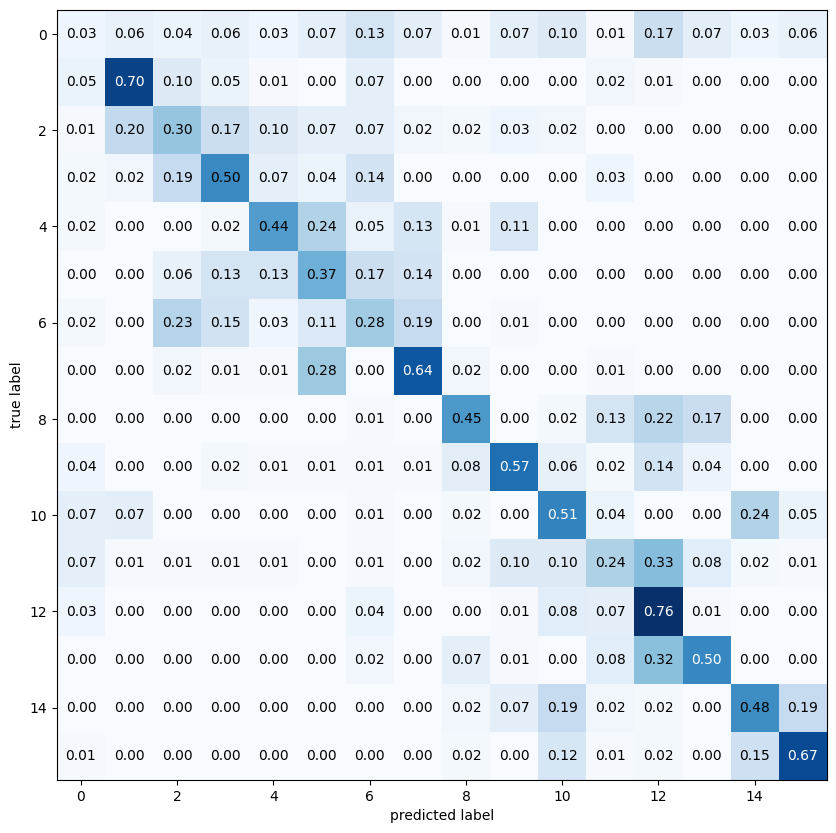

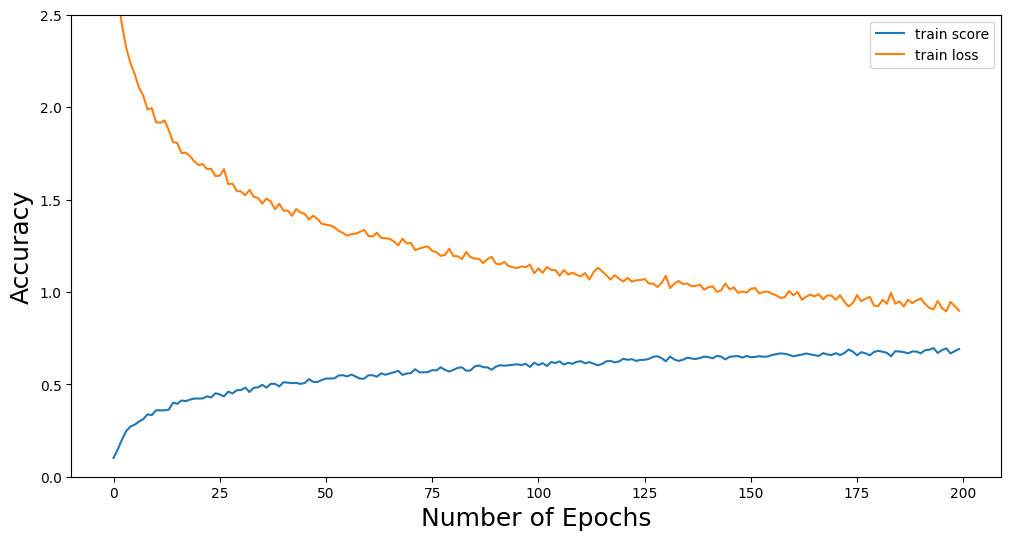

Train Data Shape: (2138, 300, 12)
Test Data Shape: (1080, 300, 12)


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_30 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_10    │ (None, 31, 64)    │          0 │ conv1d_30[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_50          │ (None, 31, 64)    │          0 │ max_pooling1d_10… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_50[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_10        │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_10[0][… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_10[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_52          │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_52[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_20 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_10[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_31 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_20[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_53          │ (None, 31, 24)    │          0 │ conv1d_31[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_53[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_32[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_21 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_20[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_21[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_54          │ (None, 128)       │          0 │ dense_20[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 424,545 (1.62 MB)

 Trainable params: 424,417 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 16s 216ms/step - accuracy: 0.0821 - loss: 2.9017
Epoch 2/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - accuracy: 0.1554 - loss: 2.5872
Epoch 3/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step - accuracy: 0.1936 - loss: 2.4499
Epoch 4/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 206ms/step - accuracy: 0.2275 - loss: 2.3338
Epoch 5/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step - accuracy: 0.2738 - loss: 2.2161
Epoch 6/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 210ms/step - accuracy: 0.3297 - loss: 2.0739
Epoch 7/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 216ms/step - accuracy: 0.3547 - loss: 1.9964
Epoch 8/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - accuracy: 0.4056 - loss: 1.8806
Epoch 9/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step - accuracy: 0.4254 - loss: 1.7897
Epoch 10/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - accuracy: 0.4248 - loss: 1.7097
Epoch 11/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 227ms/step - accuracy: 0.4427 - loss: 1.6676
Epoch 12/200
34/34 ━━━━━━━━━━━━━━━━━━

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.9235 - loss: 0.2128
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.7195 - loss: 1.0502
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
>#11: 
  train accuracy: 0.91908
  train loss    : 0.22591
  test accuracy: 0.73333
  test loss    : 0.90894

Accuracy: 0.73333 (+/-0.00000)
Loss: 0.90894 (+/-0.00000)


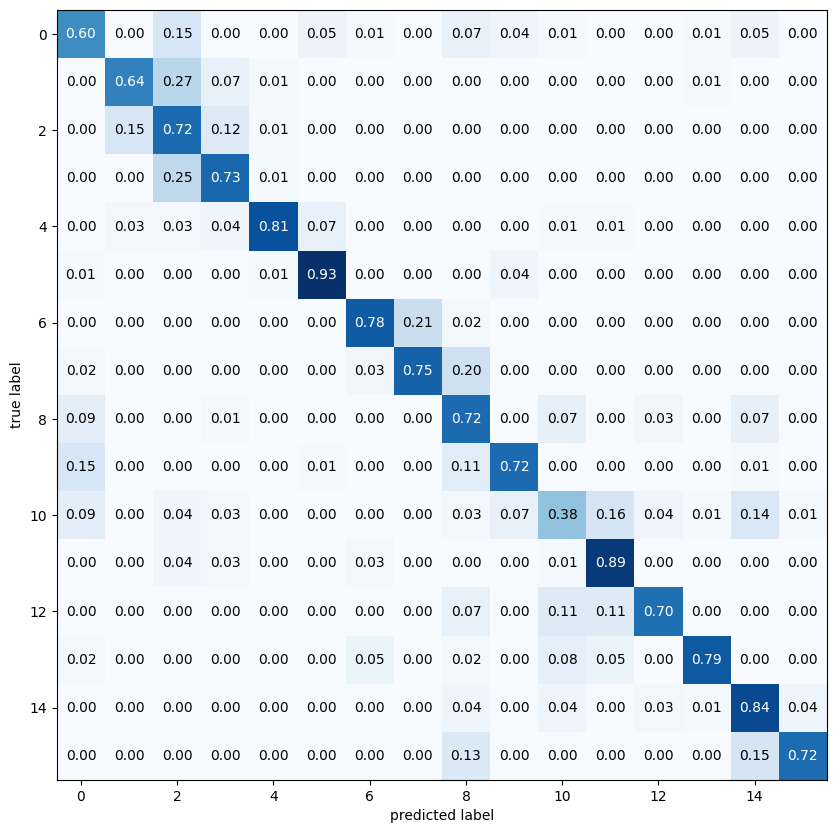

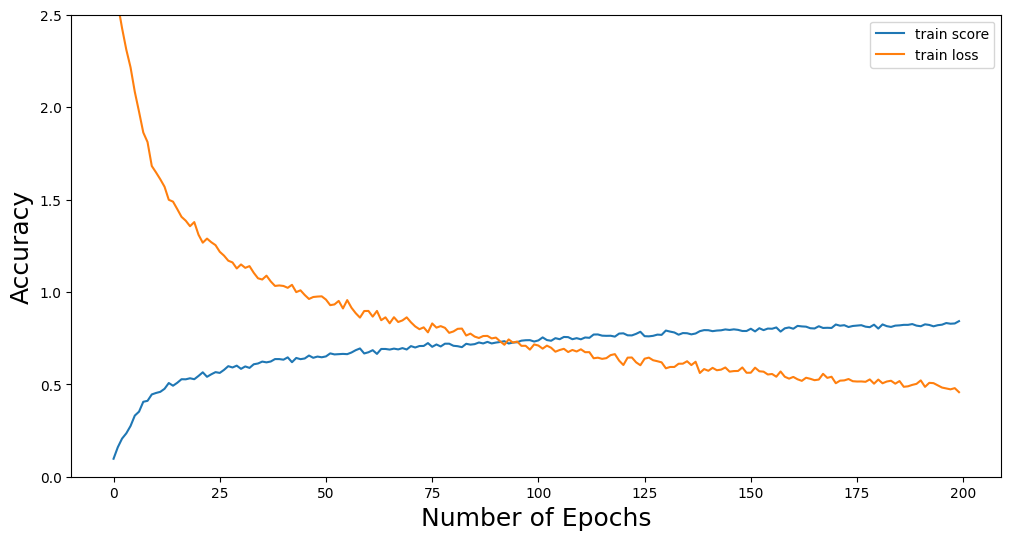

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Transformer-Based-approach-for-hand-gesture-recognition-through-EMG-signals\\DB3\\results\\v1\\general_results\\trans_global_predection.mat'

In [6]:

# Main
# ==============================================================================

globel_perd = []
globel_class = []

globel_perd1 = []
globel_class1 = []

# Create a workbook and add a worksheet.
workbook = xlsxwriter.Workbook(fr'D:\Transformer-Based-approach-for-hand-gesture-recognition-through-EMG-signals\DB3\results\v1\xlsx\Trans_DB3_rslt.xlsx')
worksheet1 = workbook.add_worksheet('Subjects informations')

# Start from the first cell. Rows and columns are zero indexed.
row = 0

worksheet1.write(row, 0, 'Subject')
worksheet1.write(row, 1, 'Train_time')
worksheet1.write(row, 2, 'Test_time')
worksheet1.write(row, 3, 'Train_acc')
worksheet1.write(row, 4, 'Train_loss')
worksheet1.write(row, 5, 'Test_acc')
worksheet1.write(row, 6, 'Test_loss')
worksheet1.write(row, 7, 'MCC')

history = History()
for i in range(1, 12):
    loss_train, score_train, loss_test, score_test, y_pred, testy, train_time, test_time = run_my_experiment(i)

    globel_perd.append(y_pred)
    globel_class.append(testy)

    globel_perd1.extend(y_pred)
    globel_class1.extend(testy)

    mcc = matthews_corrcoef(testy, y_pred)
    mat = confusion_matrix(testy, y_pred)

    cfm_plot, ax = plot_confusion_matrix(mat, figsize=(10, 10), show_normed=True, show_absolute=False)
    cfm_plot.savefig(fr'D:\Transformer-Based-approach-for-hand-gesture-recognition-through-EMG-signals\DB3\results\v1\confusion_matrix\DB3_s' + str(i) + 'trans_confusion_matrix.png')

    fig, axarr = plt.subplots(figsize=(12, 6), ncols=1)
    plot_renge = int(len(history.history['accuracy']) / i)
    global_renge = len(history.history['accuracy'])
    start_renge = global_renge - plot_renge
    axarr.plot(range(plot_renge), history.history['accuracy'][start_renge: global_renge], label='train score')
    axarr.plot(range(plot_renge), history.history['loss'][start_renge: global_renge], label='train loss')
    axarr.set_xlabel('Number of Epochs', fontsize=18)
    axarr.set_ylabel('Accuracy', fontsize=18)
    axarr.set_ylim([0, 2.5])
    plt.legend()
    plt.show()
    fig.savefig(fr'D:\Transformer-Based-approach-for-hand-gesture-recognition-through-EMG-signals\DB3\results\v1\graphs\DB3_s' + str(i) + 'trans_graphe.png')

    # Sheet informations
    worksheet1.write(i, 0, 'Sujet ' + str(i))
    worksheet1.write(i, 1, train_time)
    worksheet1.write(i, 2, test_time)
    worksheet1.write(i, 3, score_train)
    worksheet1.write(i, 4, loss_train)
    worksheet1.write(i, 5, score_test)
    worksheet1.write(i, 6, loss_test)
    worksheet1.write(i, 7, mcc)

workbook.close()

# Save prediction
new_data = {'pred_labels': globel_perd, 'class_labels': globel_class}
savemat(fr'D:\Transformer-Based-approach-for-hand-gesture-recognition-through-EMG-signals\DB3\results\v1\general_results\trans_global_predection.mat', new_data)

mat = confusion_matrix(globel_class1, globel_perd1)
cfm_plot, ax = plot_confusion_matrix(mat, figsize=(10, 10), show_normed=True, show_absolute=False)
cfm_plot.savefig(fr'D:\Transformer-Based-approach-for-hand-gesture-recognition-through-EMG-signals\DB3\results\v1\general_results\trans_global_confusion_matrix.png')


